# Imports

In [2]:
import glob
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from collections import defaultdict
import itertools

import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn import metrics, naive_bayes, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble, model_selection
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from wordcloud import WordCloud ,STOPWORDS
import seaborn as sns

from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
stop_words= stopwords.words('english')

# Data Loading Functions

In [4]:
# train_d_path = "data/en/"
# test_d_path = "../../data/en_test/"
"""
Loading the data   --- these functions are taken and modified from ashraf2019
"""


def iter_docs(author):
    author_attr = author.attrib
    doc_dict = author_attr.copy()
    doc_dict['text'] = [' '.join([doc.text for doc in author.iter('document')])]
    return doc_dict


def create_test_data_frame(input_folder):
    # os.chdir(input_folder)
    os.chdir(input_folder)
    all_xml_files = glob.glob("*.xml")
    truth_data = pd.read_csv('truth.txt', sep=':::', names=['author_id', 'author', 'gender'], engine="python")
    temp_list_of_DataFrames = []
    text_Data = pd.DataFrame()
    for file in all_xml_files:
        etree = ET.parse(file)  # create an ElementTree object
        doc_df = pd.DataFrame(iter_docs(etree.getroot()))
        doc_df['author_id'] = file[:-4]
        temp_list_of_DataFrames.append(doc_df)
    text_Data = pd.concat(temp_list_of_DataFrames, axis=0)

    data = text_Data.merge(truth_data, on='author_id')
    return data


def create_training_data_frame(input_folder, taining_div, testing_div):
    os.chdir(input_folder)
    all_xml_files = glob.glob("*.xml")
    train_truth_div_data = pd.read_csv(taining_div, sep=':::', names=['author_id', 'author', 'gender'], engine="python")
    test_truth_div_data = pd.read_csv(testing_div, sep=':::', names=['author_id', 'author', 'gender'], engine="python")
    temp_list_of_DataFrames = []
    text_Data = pd.DataFrame()
    for file in all_xml_files:
        etree = ET.parse(file)  # create an ElementTree object
        doc_df = pd.DataFrame(iter_docs(etree.getroot()))
        doc_df['author_id'] = file[:-4]
        temp_list_of_DataFrames.append(doc_df)
    text_Data = pd.concat(temp_list_of_DataFrames, axis=0)
    training_data = text_Data.merge(train_truth_div_data, on='author_id')
    testing_data = text_Data.merge(test_truth_div_data, on='author_id')
    return training_data, testing_data

# Step 1  - Training Data split and exploration

In [5]:
# change the paths according to your system
en_training_div_data, en_testing_div_data = create_training_data_frame(
                                            "C:/Users/VivAndMourhaf/PycharmProjects/HelloWorld/data/en", 
                                            'truth-train.txt', 'truth-dev.txt')

In [6]:
print("English training data split size", len(en_training_div_data))
print("English testing data split size", len(en_testing_div_data))

English training data split size 2880
English testing data split size 1240


In [7]:
en_training_div_data.head()  # how the training data looks like

,lang,text,author_id,author,gender
0,en,RT @OnlyInBOS: ALERT: The deadline to register...,100e80cf6283b11b25f05f4d673947ea,human,female
1,en,"RT @Gardner_LM: Per pool, Dep Sec Jeffrey Rose...",10142b769515b97369d36b9c0c47383b,human,female
2,en,RT @BillardArch: Yup. @BenKielb @BlackBerry is...,1014403fecf2a8ac15264e80e6513450,human,male
3,en,RT @Apple_Joyride: Google adds ‘Smart Replies’...,1023e968a8aa69cf5b659aa57a478f64,bot,bot
4,en,“‘Algebra’ roughly translates to ‘the system f...,1037959ad55f8330730a29632b480eb7,bot,bot


In [8]:
en_training_div_data['author'].unique()  # there are only two values in author

array(['human', 'bot'], dtype=object)

In [9]:
en_training_div_data.shape  # 2880 enties with 5 columns

(2880, 5)

In [10]:
en_training_div_data.isnull().any()   # none of the columns has empty entries

lang         False
text         False
author_id    False
author       False
gender       False
dtype: bool

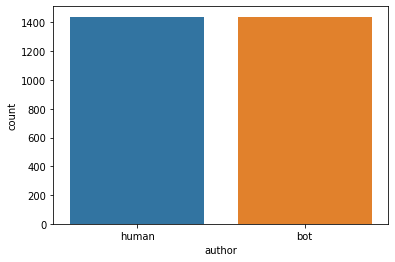

In [11]:
sns.countplot(en_training_div_data.author)   # data distribution is exactly even

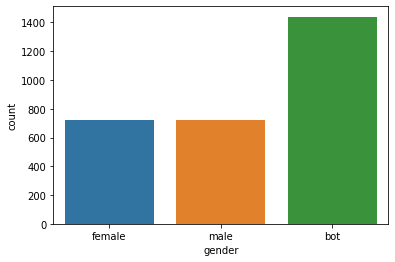

In [12]:
sns.countplot(en_training_div_data.gender)  # in gender: bot is twice the size of male/female

In [13]:
en_training_div_data['tweet_length'] = en_training_div_data['text'].str.len()
print(en_training_div_data['tweet_length'])    

0       12356
1       12312
2        9860
3       12336
4       12743
        ...  
2875    10147
2876     8168
2877     8432
2878     9299
2879    13217
Name: tweet_length, Length: 2880, dtype: int64


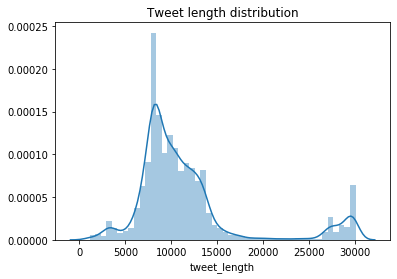

In [14]:
sns.distplot(en_training_div_data['tweet_length']).set_title('Tweet length distribution');  
# most tweet bodies are between 5000 and 15000 chars

# Wordclouds

In [15]:
def create_wordcloud(words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

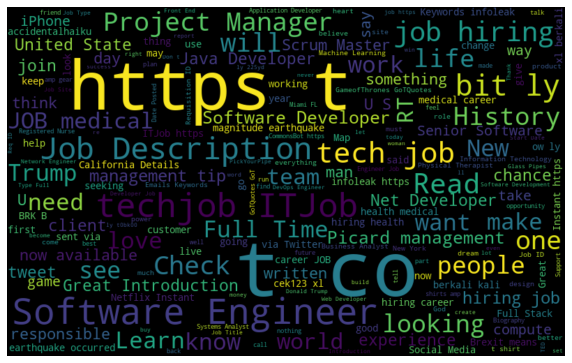

In [16]:
subset=en_training_div_data[en_training_div_data.author=="bot"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)
# common words in author/bot

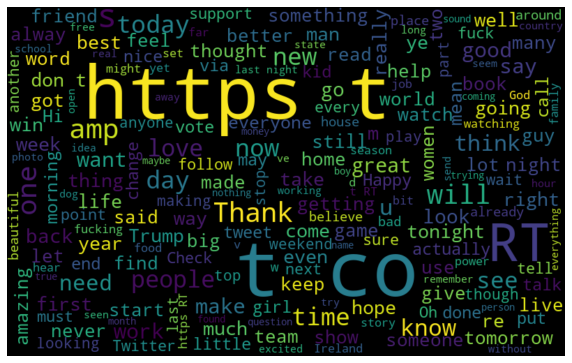

In [17]:
subset=en_training_div_data[en_training_div_data.author=="human"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)
# common words in author/human

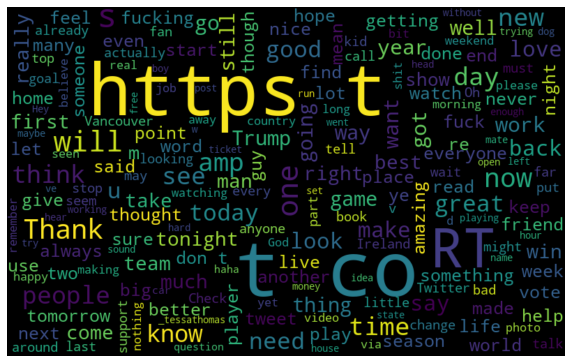

In [18]:
subset=en_training_div_data[en_training_div_data.gender=="male"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)
# common words in gender/male

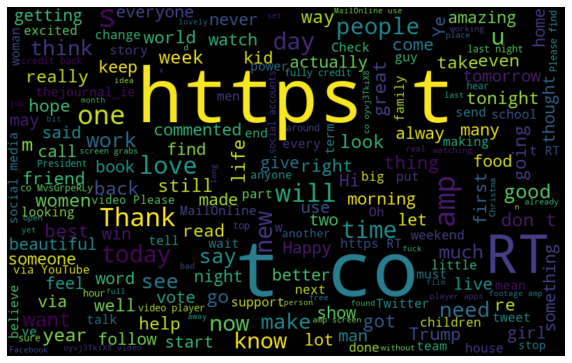

In [19]:
subset=en_training_div_data[en_training_div_data.gender=="female"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)
# common words in gender/female

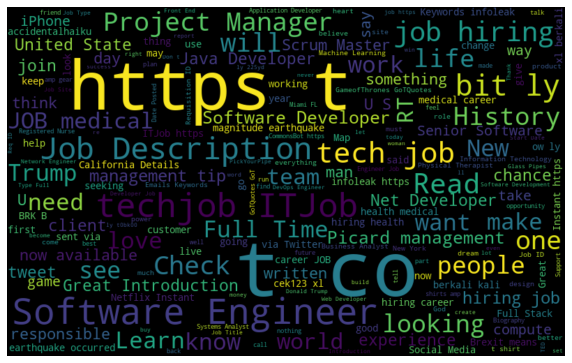

In [20]:
subset=en_training_div_data[en_training_div_data.gender=="bot"]
text=subset.text.values
words =" ".join(text)
create_wordcloud(words)
# common words in gender/bot

# Step 2 - Preprocessing and finding the most common words across the corpus 

In [21]:
# gensim only accepts tokenized lists
# so this preprocesses and coverts tweet-body strings into tokens
# to do: we could use nltk.TweetTokenizer and see what happens. 
# to do: we could try different lemmatization libraries
def build_tokenized_corpus(data):
    corpus = []
    for i in range(0, len(data)):  # len(X)
        tweet = str(data[i])
        tweet = tweet.lower()
        # Extra layers Lorena
        tweet = re.sub(r'https?:\/\/.\S*', 'URL', tweet)  # replace every url for a custom word
        tweet = re.sub(r'@.\S*', 'MENTION', tweet)  # replace every mention for a custom word
        tweet = re.sub(r'#.\S*', 'HASHTAG', tweet)  # replace every hashtag for a custom word
        tweet = re.sub(r'".*"', 'QUOTE', tweet)  # replace every quote for a custom word
#         tweet = re.sub(r'@.\S*', '', tweet)  # removes every mention
#         tweet = re.sub(r'#.\S*', '', tweet)  # removes every hashtag
#         tweet = re.sub(r'".*"', '', tweet)  # removes every quote
        # tweet = re.sub(r'\W', ' ', tweet)  # remove non-w chars
        tweet = re.sub(r'\s+[a-z]\s+', ' ', tweet)  # remove single characters like i and a
        tweet = re.sub(r'^[a-z]\s+', ' ', tweet)  # remove single characters at the beginning like i and a
        tweet = re.sub(r'\s+', ' ', tweet)  # remove our extra spaces

        # lemmatize words
        tweet = word_tokenize(tweet)
        tweet = [w for w in tweet if w not in stop_words]
#         tweet = [stemmer.stem(w) for w in tweet]
#         tweet = ' '.join([lemmatizer.lemmatize(w) for w in tweet])
        corpus.append(tweet)
    return corpus

In [22]:
processed_train_split_corpus = build_tokenized_corpus(en_training_div_data['text'])
processed_test_split_corpus = build_tokenized_corpus(en_testing_div_data['text'])
print("ready")

ready


In [23]:
# this is how the tokenization and preprocessing looks like
# to do: might need deminsionality reduction
df = pd.DataFrame(processed_train_split_corpus)
df

,0,1,2,3,4,5,6,7,8,9,...,3967,3968,3969,3970,3971,3972,3973,3974,3975,3976
0,rt,MENTION,alert,:,deadline,register,vote,massachusetts,state,primary,...,None,None,None,None,None,None,None,None,None,None
1,rt,MENTION,per,pool,",",dep,sec,jeffrey,rosen,representing,...,None,None,None,None,None,None,None,None,None,None
2,rt,MENTION,yup,.,MENTION,MENTION,best,phone,brand,'ve,...,None,None,None,None,None,None,None,None,None,None
3,rt,MENTION,google,adds,‘,smart,replies,’,gmail,ios,...,None,None,None,None,None,None,None,None,None,None
4,“,‘,algebra,’,roughly,translates,‘,system,reconciling,disparate,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,rt,MENTION,nope,.,rt,MENTION,anyone,else,miss,thad,...,None,None,None,None,None,None,None,None,None,None
2876,&,HASHTAG,cussing,time,|,stock,picks,discussion,...,URL,...,None,None,None,None,None,None,None,None,None,None
2877,___buyselltrade,:,selling/looking,URL,everyone,world,wanted,1-ounce,gold,coin,...,None,None,None,None,None,None,None,None,None,None
2878,republicans,5-0,recent,congressional,races,",",point,dems,want,shutdown,...,None,None,None,None,None,None,None,None,None,None


# The process of finding the common words with TFIDF gensim

In [24]:
# gensim dictionary
dictionary = Dictionary(processed_train_split_corpus)

In [26]:
# tweet_body or doc to bag of word
corpus = [dictionary.doc2bow(doc) for doc in processed_train_split_corpus]

In [27]:
unwanted_most_common_words = {}
# Create the defaultdict: total_word_count
total_word_count = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus):
    total_word_count[word_id] += word_count

# Create a sorted list from the defaultdict: sorted_word_count 
sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True) 

# find the top 500 words across all documents alongside the count
for word_id, word_count in sorted_word_count[:500]:
    unwanted_most_common_words[dictionary.get(word_id)] = word_count
#     print(dictionary.get(word_id), word_count)
# print(unwanted_most_common)

# We need to keep track of the special tags we created in the preprocessing
# so we just popped them from the 500 list
unwanted_most_common_words.pop("URL")
unwanted_most_common_words.pop("MENTION")
unwanted_most_common_words.pop("HASHTAG")
unwanted_most_common_words.pop("QUOTE")
print(unwanted_most_common_words)

{',': 116900, '.': 112224, ':': 70929, 'rt': 50238, '!': 45930, '-': 28244, '’': 24463, '–': 21696, '?': 21595, "'s": 20522, '(': 19507, ')': 19423, ';': 15781, '&': 13430, '...': 12678, 'amp': 10973, "n't": 10640, 'job': 10335, 'engineer': 9028, 'new': 8750, 'developer': 8561, 'software': 8329, 'one': 8067, 'get': 7189, 'like': 7047, 'time': 6531, 'people': 6311, 'us': 5559, 'great': 5523, '/': 5473, '[': 5254, 'work': 5243, 'senior': 5173, ']': 5046, 'good': 4921, 'today': 4885, 'day': 4857, 'trump': 4731, '$': 4686, 'see': 4649, '“': 4635, 'description': 4553, 'love': 4279, "'": 4233, 'know': 4209, 'business': 4182, "'m": 4147, 'manager': 4113, '%': 4074, 'would': 4046, 'team': 3947, '”': 3869, 'location': 3838, 'data': 3807, 'back': 3755, 'world': 3733, 'looking': 3712, 'make': 3692, 'life': 3685, 'read': 3611, 'please': 3603, 'want': 3554, 'need': 3475, 'think': 3447, 'support': 3432, '…': 3429, 'experience': 3421, 'best': 3418, 'project': 3406, 'go': 3370, "'re": 3366, 'analyst':

In [28]:
# extract only the keys
unwanted= list(unwanted_most_common_words.keys())

In [ ]:
# We need to convert the lists of tokens back to tweet_bodies
# while deleting all unwanted tokens

In [29]:
def combine_tokens_into_tweets(data):
    corpus = []
    for i in range(0, len(data)):  # len(X)
        tweet = data[i]
        tweet = ' '.join([w for w in tweet])
        corpus.append(tweet)
    return corpus

def remove_words_from_tweets(data):
    corpus = []
    for i in range(0, len(data)):  # len(X)
        # tweet = re.sub(r'\W', ' ', str(data[i]))  # remove non-w chars
        tweet = data[i].split()
        tweet = ' '.join([w for w in tweet if w not in unwanted])
        corpus.append(tweet)
    return corpus

In [31]:
combined_training = combine_tokens_into_tweets(processed_train_split_corpus)
combined_testing = combine_tokens_into_tweets(processed_test_split_corpus)
df = pd.DataFrame(combined_training)
df

,0
0,rt MENTION alert : deadline register vote mass...
1,"rt MENTION per pool , dep sec jeffrey rosen re..."
2,rt MENTION yup . MENTION MENTION best phone br...
3,rt MENTION google adds ‘ smart replies ’ gmail...
4,“ ‘ algebra ’ roughly translates ‘ system reco...
...,...
2875,rt MENTION nope . rt MENTION anyone else miss ...
2876,& HASHTAG cussing time | stock picks discussio...
2877,___buyselltrade : selling/looking URL everyone...
2878,"republicans 5-0 recent congressional races , p..."


In [33]:
# final processed splits --> ready to for ML
processed_training_corpus=  remove_words_from_tweets(combined_training)
processed_testing_corpus=  remove_words_from_tweets(combined_testing)
df = pd.DataFrame(processed_training_corpus)
df

,0
0,MENTION alert deadline register massachusetts ...
1,MENTION per pool dep sec jeffrey rosen represe...
2,MENTION yup MENTION MENTION phone brand 11 pas...
3,MENTION adds smart replies gmail ios URL URL M...
4,algebra roughly translates reconciling dispara...
...,...
2875,MENTION nope MENTION else miss thad mccotter w...
2876,HASHTAG cussing stock picks discussion URL inv...
2877,___buyselltrade selling/looking URL wanted 1-o...
2878,republicans 5-0 recent congressional races poi...


In [38]:
# convert human/bot categories to 1/0 and ready for ML
# to do : could use a library to do this
def set_labels(data):
    labels = []
    for j in range(0, len(data)):
        if data[j] == "human":
            clas = 1
        else:
            clas = 0
        labels.append(clas)
    return labels
training_corpus_labels = set_labels(en_training_div_data['author'])
testing_corpus_labels = set_labels(en_testing_div_data['author'])

# Step 3  - Vectorizing using TFIDF and 1-5 grams

In [35]:
# to do: we can tune the hyperparameters of the vectorizer 
# to find the ultimate ngram and max_feature configuration
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,5), max_features=500)
vectorized_en_training_div_tweets = vectorizer.fit_transform(processed_training_corpus).toarray()
vectorized_en_testing_div_tweets = vectorizer.transform(processed_testing_corpus).toarray()
print("vectorization ready")

vectorization ready


# Step 4 - ML models hyperparameter tuning to find the best models

In [36]:
# parameter dictionary to apply gridsearchCV on and find 
# the best model for the task humna/bot
# given the vectorizer above
# to do: add more combinations
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': ensemble.RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10, 50, 100, 200, 400, 500, 700]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10, 50, 100]
        }
    },
    'naive_bayes_gaussian': {
        'model': GaussianNB(),
        'params': {}
    },
    'naive_bayes_multinomial': {
        'model': MultinomialNB(),
        'params': {}
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
        }
    }    
}


In [39]:
# manual gridsearchCV
# to do: can be done much better with hyperopt
# english bot/human
evaluation_en_human_bot = []
for model_name, mp in model_params.items():
        clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False )
        clf.fit(vectorized_en_training_div_tweets,training_corpus_labels)
        evaluation_en_human_bot.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
df = pd.DataFrame(evaluation_en_human_bot, columns=['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,svm,0.970486,"{'C': 20, 'kernel': 'linear'}"
1,random_forest,0.968403,{'n_estimators': 400}
2,logistic_regression,0.971875,{'C': 100}
3,naive_bayes_gaussian,0.886111,{}
4,naive_bayes_multinomial,0.918403,{}
5,decision_tree,0.960417,{'criterion': 'gini'}


In [57]:
# test area 
# change the hyperparameters of the model and the model according to the chart above
print("Human/Bot: English - testing split test accuracy ")

en_ML_model = SVC(C=20, kernel='linear')
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels)
print("SVM:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels))
print(classification_report(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels))
print("-----------------------------------------")


en_ML_model = ensemble.RandomForestClassifier(n_estimators= 400)
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels)
print("Random forest:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels))
print(classification_report(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels))
print("-----------------------------------------")

en_ML_model = GaussianNB()
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels)
print("Naive Bayes G:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels))
print(classification_report(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels))
print("-----------------------------------------")


en_ML_model = MultinomialNB()
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels)
print("Naive Bayes MN:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels))
print(classification_report(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels))
print("-----------------------------------------")


en_ML_model = DecisionTreeClassifier(criterion='gini')
en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels)
print("Decision Tree:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels))
print(classification_report(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels))

# logistic regression needs data scaling
# en_ML_model = LogisticRegression(C= 100)
# en_ML_model.fit(vectorized_en_training_div_tweets,training_corpus_labels)
# print("Naive Bayes G:" , accuracy_score(en_ML_model.predict(vectorized_en_testing_div_tweets),testing_corpus_labels))


Human/Bot: English - testing split test accuracy 
SVM: 0.8846774193548387
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       513
           1       0.97      0.83      0.89       727

    accuracy                           0.88      1240
   macro avg       0.88      0.90      0.88      1240
weighted avg       0.90      0.88      0.89      1240

-----------------------------------------
Random forest: 0.9169354838709678
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       537
           1       0.98      0.87      0.92       703

    accuracy                           0.92      1240
   macro avg       0.92      0.92      0.92      1240
weighted avg       0.93      0.92      0.92      1240

-----------------------------------------
Naive Bayes G: 0.8370967741935483
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       496
           

In [ ]:
"""
NOTES:
1- the preprocessing can be split into es_preprocess and en_preprocess to process each language separately
2- The tuning is showing potential for more accuracy but I cannot figure out how to make the ml model reflect it. 
    for now, the default param scores higher. I wonder how pizzaro 2019 did it.
3- We can add more word clouds to see the change after the removel of 500 words
"""